In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

In [0]:
from keras.layers import *
from keras.layers.merge import concatenate
from keras.models import Model
from keras.backend import reverse

In [0]:
max_words = 30000
max_words_length = 400
embedding_dimension = 300

lstm_options = {
    'units': 32,
    'dropout': 0.2,
    'return_sequences': True
}

convolution_options = {
    'filters': 300,
    'kernel_size': 1,
    'strides': 1,
    'padding': 'valid'
}

In [0]:
def forward_lstm(comment_embedding):
    lstm = CuDNNLSTM(
        units=lstm_options['units'], 
        return_sequences=lstm_options['return_sequences']
    )(comment_embedding)
    lstm = Dropout(lstm_options['dropout'])(lstm)
    
    return lstm

def backward_lstm(comment_embedding):
    reversed_embeddings = Lambda(lambda x: reverse(x, axes=1))(comment_embedding)
    lstm = CuDNNLSTM(
        units=lstm_options['units'], 
        return_sequences=lstm_options['return_sequences']
    )(reversed_embeddings)   
    lstm = Dropout(lstm_options['dropout'])(lstm)

    return Lambda(lambda x: reverse(x, axes=1))(lstm)

def convolution_block(context, options):
    convolution_block = Conv1D(
        options['filters'], 
        options['kernel_size'], 
        strides=options['strides'],
        padding=options['padding'], 
        activation='linear', 
        kernel_initializer='he_normal'
    )(context)
    convolution_block = BatchNormalization()(convolution_block)
    convolution_block = Activation('tanh')(convolution_block)

    return convolution_block

In [0]:
def yoon_kim_feature_extractor(input_layer, filters):
    extractor_block_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    block_1_conv_1 = Conv1D(filters, 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_batchnorm1 = ELU()(block_1_batchnorm1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filters, 2, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_batchnorm2 = ELU()(block_1_batchnorm2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filters, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_batchnorm3 = ELU()(block_1_batchnorm3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filters, 5, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_batchnorm4 = ELU()(block_1_batchnorm4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    
    extractor_block_output = Dropout(0.2)(features)
    
    return Model(
        inputs=[extractor_block_input], 
        outputs=[extractor_block_output]
    )(input_layer)

In [0]:
def classification_block(input_layer, dropout_rate=0.2):
    model = Dense(256, activation='linear', kernel_initializer='he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    model = Dense(256, activation='linear', kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    return Dense(6, activation='sigmoid', kernel_initializer='glorot_normal')(model)

In [13]:
input_layer = Input(shape=(max_words_length,))

pretrained_embedding_layer = Embedding(
    max_words,
    output_dim=embedding_dimension,
    input_length=max_words_length,
    weights=[np.load('fast_text_embeddings.npy')],
    trainable=False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    max_words,
    output_dim=embedding_dimension,
    input_length=max_words_length,
    weights=[np.load('custom_fast_text_embeddings.npy')],
    trainable=False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

averaged_embedding_layer = Average()([pretrained_embedding_layer, custom_embedding_layer])
averaged_embedding_layer = SpatialDropout1D(0.2)(averaged_embedding_layer)

context = concatenate([
    forward_lstm(averaged_embedding_layer),
    averaged_embedding_layer,
    backward_lstm(averaged_embedding_layer)
])
context = Dropout(0.2)(context)

scaled_context = convolution_block(context, convolution_options)
pooled_features = concatenate([
    yoon_kim_feature_extractor(scaled_context, convolution_options['filters']),
    GlobalMaxPooling1D()(scaled_context),
    GlobalAveragePooling1D()(scaled_context)
])

output_layer = classification_block(pooled_features, dropout_rate=0.2)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [14]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21312/102124 [=====>........................] - ETA: 9:47 - loss: 0.1132 - acc: 0.9611

102112/102124 [============================>.] - ETA: 0s - loss: 0.0706 - acc: 0.9751

102124/102124 [==============================] - 778s 8ms/step - loss: 0.0706 - acc: 0.9751 - val_loss: 0.0508 - val_acc: 0.9806
Epoch 2/32
 10144/102124 [=>............................] - ETA: 10:47 - loss: 0.0531 - acc: 0.9802

102112/102124 [============================>.] - ETA: 0s - loss: 0.0516 - acc: 0.9809

102124/102124 [==============================] - 775s 8ms/step - loss: 0.0516 - acc: 0.9809 - val_loss: 0.0458 - val_acc: 0.9829
roc-auc: 0.9855 - roc-auc_val: 0.9814                                                                                                    
Epoch 3/32
  8672/102124 [=>............................] - ETA: 11:02 - loss: 0.0490 - acc: 0.9814

102112/102124 [============================>.] - ETA: 0s - loss: 0.0482 - acc: 0.9817

102124/102124 [==============================] - 775s 8ms/step - loss: 0.0482 - acc: 0.9817 - val_loss: 0.0445 - val_acc: 0.9822
Epoch 4/32
 10144/102124 [=>............................] - ETA: 10:46 - loss: 0.0434 - acc: 0.9832

102112/102124 [============================>.] - ETA: 0s - loss: 0.0456 - acc: 0.9826

102124/102124 [==============================] - 775s 8ms/step - loss: 0.0456 - acc: 0.9826 - val_loss: 0.0411 - val_acc: 0.9843
roc-auc: 0.9901 - roc-auc_val: 0.9871                                                                                                    
Epoch 5/32
  8672/102124 [=>............................] - ETA: 11:01 - loss: 0.0466 - acc: 0.9819

102112/102124 [============================>.] - ETA: 0s - loss: 0.0439 - acc: 0.9831

102124/102124 [==============================] - 773s 8ms/step - loss: 0.0439 - acc: 0.9831 - val_loss: 0.0404 - val_acc: 0.9843
Epoch 6/32
 10144/102124 [=>............................] - ETA: 10:49 - loss: 0.0435 - acc: 0.9834

102112/102124 [============================>.] - ETA: 0s - loss: 0.0425 - acc: 0.9837

102124/102124 [==============================] - 776s 8ms/step - loss: 0.0425 - acc: 0.9837 - val_loss: 0.0398 - val_acc: 0.9844
roc-auc: 0.9918 - roc-auc_val: 0.9881                                                                                                    
Epoch 7/32
  8672/102124 [=>............................] - ETA: 11:00 - loss: 0.0407 - acc: 0.9836

102112/102124 [============================>.] - ETA: 0s - loss: 0.0414 - acc: 0.9838

102124/102124 [==============================] - 774s 8ms/step - loss: 0.0414 - acc: 0.9838 - val_loss: 0.0410 - val_acc: 0.9839
Epoch 8/32
 10144/102124 [=>............................] - ETA: 10:49 - loss: 0.0388 - acc: 0.9851

102112/102124 [============================>.] - ETA: 0s - loss: 0.0404 - acc: 0.9841

102124/102124 [==============================] - 777s 8ms/step - loss: 0.0404 - acc: 0.9841 - val_loss: 0.0391 - val_acc: 0.9847
roc-auc: 0.993 - roc-auc_val: 0.9885                                                                                                    
Epoch 9/32
  8704/102124 [=>............................] - ETA: 11:00 - loss: 0.0396 - acc: 0.9850

102112/102124 [============================>.] - ETA: 0s - loss: 0.0397 - acc: 0.9845

102124/102124 [==============================] - 774s 8ms/step - loss: 0.0397 - acc: 0.9845 - val_loss: 0.0393 - val_acc: 0.9847
Epoch 10/32
 10112/102124 [=>............................] - ETA: 10:47 - loss: 0.0379 - acc: 0.9851

102112/102124 [============================>.] - ETA: 0s - loss: 0.0387 - acc: 0.9847

102124/102124 [==============================] - 775s 8ms/step - loss: 0.0387 - acc: 0.9847 - val_loss: 0.0390 - val_acc: 0.9848
roc-auc: 0.9937 - roc-auc_val: 0.989                                                                                                    
Epoch 11/32
  8672/102124 [=>............................] - ETA: 11:01 - loss: 0.0374 - acc: 0.9854

102112/102124 [============================>.] - ETA: 0s - loss: 0.0381 - acc: 0.9850

102124/102124 [==============================] - 776s 8ms/step - loss: 0.0381 - acc: 0.9850 - val_loss: 0.0392 - val_acc: 0.9845
Epoch 12/32
 10112/102124 [=>............................] - ETA: 10:49 - loss: 0.0378 - acc: 0.9853

102112/102124 [============================>.] - ETA: 0s - loss: 0.0374 - acc: 0.9852

102124/102124 [==============================] - 776s 8ms/step - loss: 0.0374 - acc: 0.9852 - val_loss: 0.0391 - val_acc: 0.9848

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0001593200722709298.
roc-auc: 0.9944 - roc-auc_val: 0.9893                                                                                                    
Epoch 13/32
  5920/102124 [>.............................] - ETA: 11:19 - loss: 0.0379 - acc: 0.9848

102112/102124 [============================>.] - ETA: 0s - loss: 0.0365 - acc: 0.9856

102124/102124 [==============================] - 774s 8ms/step - loss: 0.0365 - acc: 0.9856 - val_loss: 0.0392 - val_acc: 0.9846
Epoch 14/32
 10112/102124 [=>............................] - ETA: 10:47 - loss: 0.0345 - acc: 0.9860

102112/102124 [============================>.] - ETA: 0s - loss: 0.0358 - acc: 0.9858

102124/102124 [==============================] - 776s 8ms/step - loss: 0.0358 - acc: 0.9858 - val_loss: 0.0393 - val_acc: 0.9847
roc-auc: 0.9951 - roc-auc_val: 0.989                                                                                                    
Epoch 15/32
  8672/102124 [=>............................] - ETA: 11:02 - loss: 0.0359 - acc: 0.9860

102112/102124 [============================>.] - ETA: 0s - loss: 0.0356 - acc: 0.9859

102124/102124 [==============================] - 776s 8ms/step - loss: 0.0356 - acc: 0.9859 - val_loss: 0.0391 - val_acc: 0.9847
Epoch 16/32
 10112/102124 [=>............................] - ETA: 10:50 - loss: 0.0357 - acc: 0.9856

102112/102124 [============================>.] - ETA: 0s - loss: 0.0347 - acc: 0.9862

102124/102124 [==============================] - 777s 8ms/step - loss: 0.0347 - acc: 0.9862 - val_loss: 0.0396 - val_acc: 0.9846
roc-auc: 0.9956 - roc-auc_val: 0.9893                                                                                                    
Epoch 17/32
  8672/102124 [=>............................] - ETA: 11:00 - loss: 0.0355 - acc: 0.9858

102112/102124 [============================>.] - ETA: 0s - loss: 0.0340 - acc: 0.9864

102124/102124 [==============================] - 776s 8ms/step - loss: 0.0340 - acc: 0.9864 - val_loss: 0.0399 - val_acc: 0.9843
Epoch 18/32
 10112/102124 [=>............................] - ETA: 10:53 - loss: 0.0323 - acc: 0.9868

102112/102124 [============================>.] - ETA: 0s - loss: 0.0336 - acc: 0.9866

102124/102124 [==============================] - 780s 8ms/step - loss: 0.0336 - acc: 0.9866 - val_loss: 0.0400 - val_acc: 0.9842
roc-auc: 0.9962 - roc-auc_val: 0.9892                                                                                                    
Epoch 19/32
  8672/102124 [=>............................] - ETA: 11:03 - loss: 0.0334 - acc: 0.9865

102112/102124 [============================>.] - ETA: 0s - loss: 0.0333 - acc: 0.9867

102124/102124 [==============================] - 779s 8ms/step - loss: 0.0332 - acc: 0.9867 - val_loss: 0.0396 - val_acc: 0.9845
Epoch 20/32
 10112/102124 [=>............................] - ETA: 10:52 - loss: 0.0300 - acc: 0.9878

102112/102124 [============================>.] - ETA: 0s - loss: 0.0327 - acc: 0.9869

102124/102124 [==============================] - 779s 8ms/step - loss: 0.0327 - acc: 0.9869 - val_loss: 0.0399 - val_acc: 0.9844
roc-auc: 0.9965 - roc-auc_val: 0.9886                                                                                                    


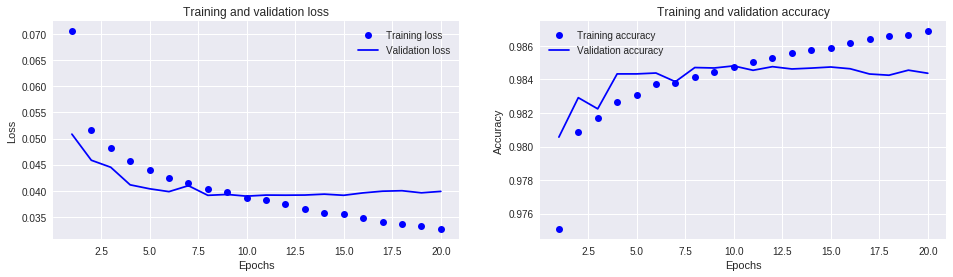

In [15]:
plot_history(history)

In [16]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 73s 2ms/step
([0.03833338105480592, 0.9848764810352215], 0.9904355192246929)
